In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
cd /content/drive/My Drive/DogBreedData

/content/drive/My Drive/DogBreedData


In [34]:
# from google.colab import files
# files.upload()

In [35]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !rm kaggle.json

In [36]:
# !kaggle competitions download -c dog-breed-identification --force

In [37]:
# !unzip "/content/drive/MyDrive/DogBreedData/dog-breed-identification.zip" -d "/content/drive/MyDrive/DogBreedData/"

# End to End Multi-class Dog Breed Classification

Think notebook is end to end Image Classification of Dog Breed.

## 1. Problem
Identifying do breed in given Image.

## 2. Data
Data obtained from Kaggle
https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
Prediction probabilities for each dog of test image
https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features
* Data is in Image(Unstructured data) form.
* Contains 120 dog breeds (120 different classes).
* 10,000+ Images in training set.

In [38]:
# Import TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("TG version: ", tf.__version__)

# Check GPU avalability
print("GPU", "available(YES!!!!!)") if tf.config.list_physical_devices("GPU") else "GPU Not available"

TG version:  2.14.0
GPU available(YES!!!!!)


In [39]:
## Check lables of our data
labels_csv = pd.read_csv("labels.csv")
labels_csv.columns

Index(['id', 'breed'], dtype='object')

<Axes: >

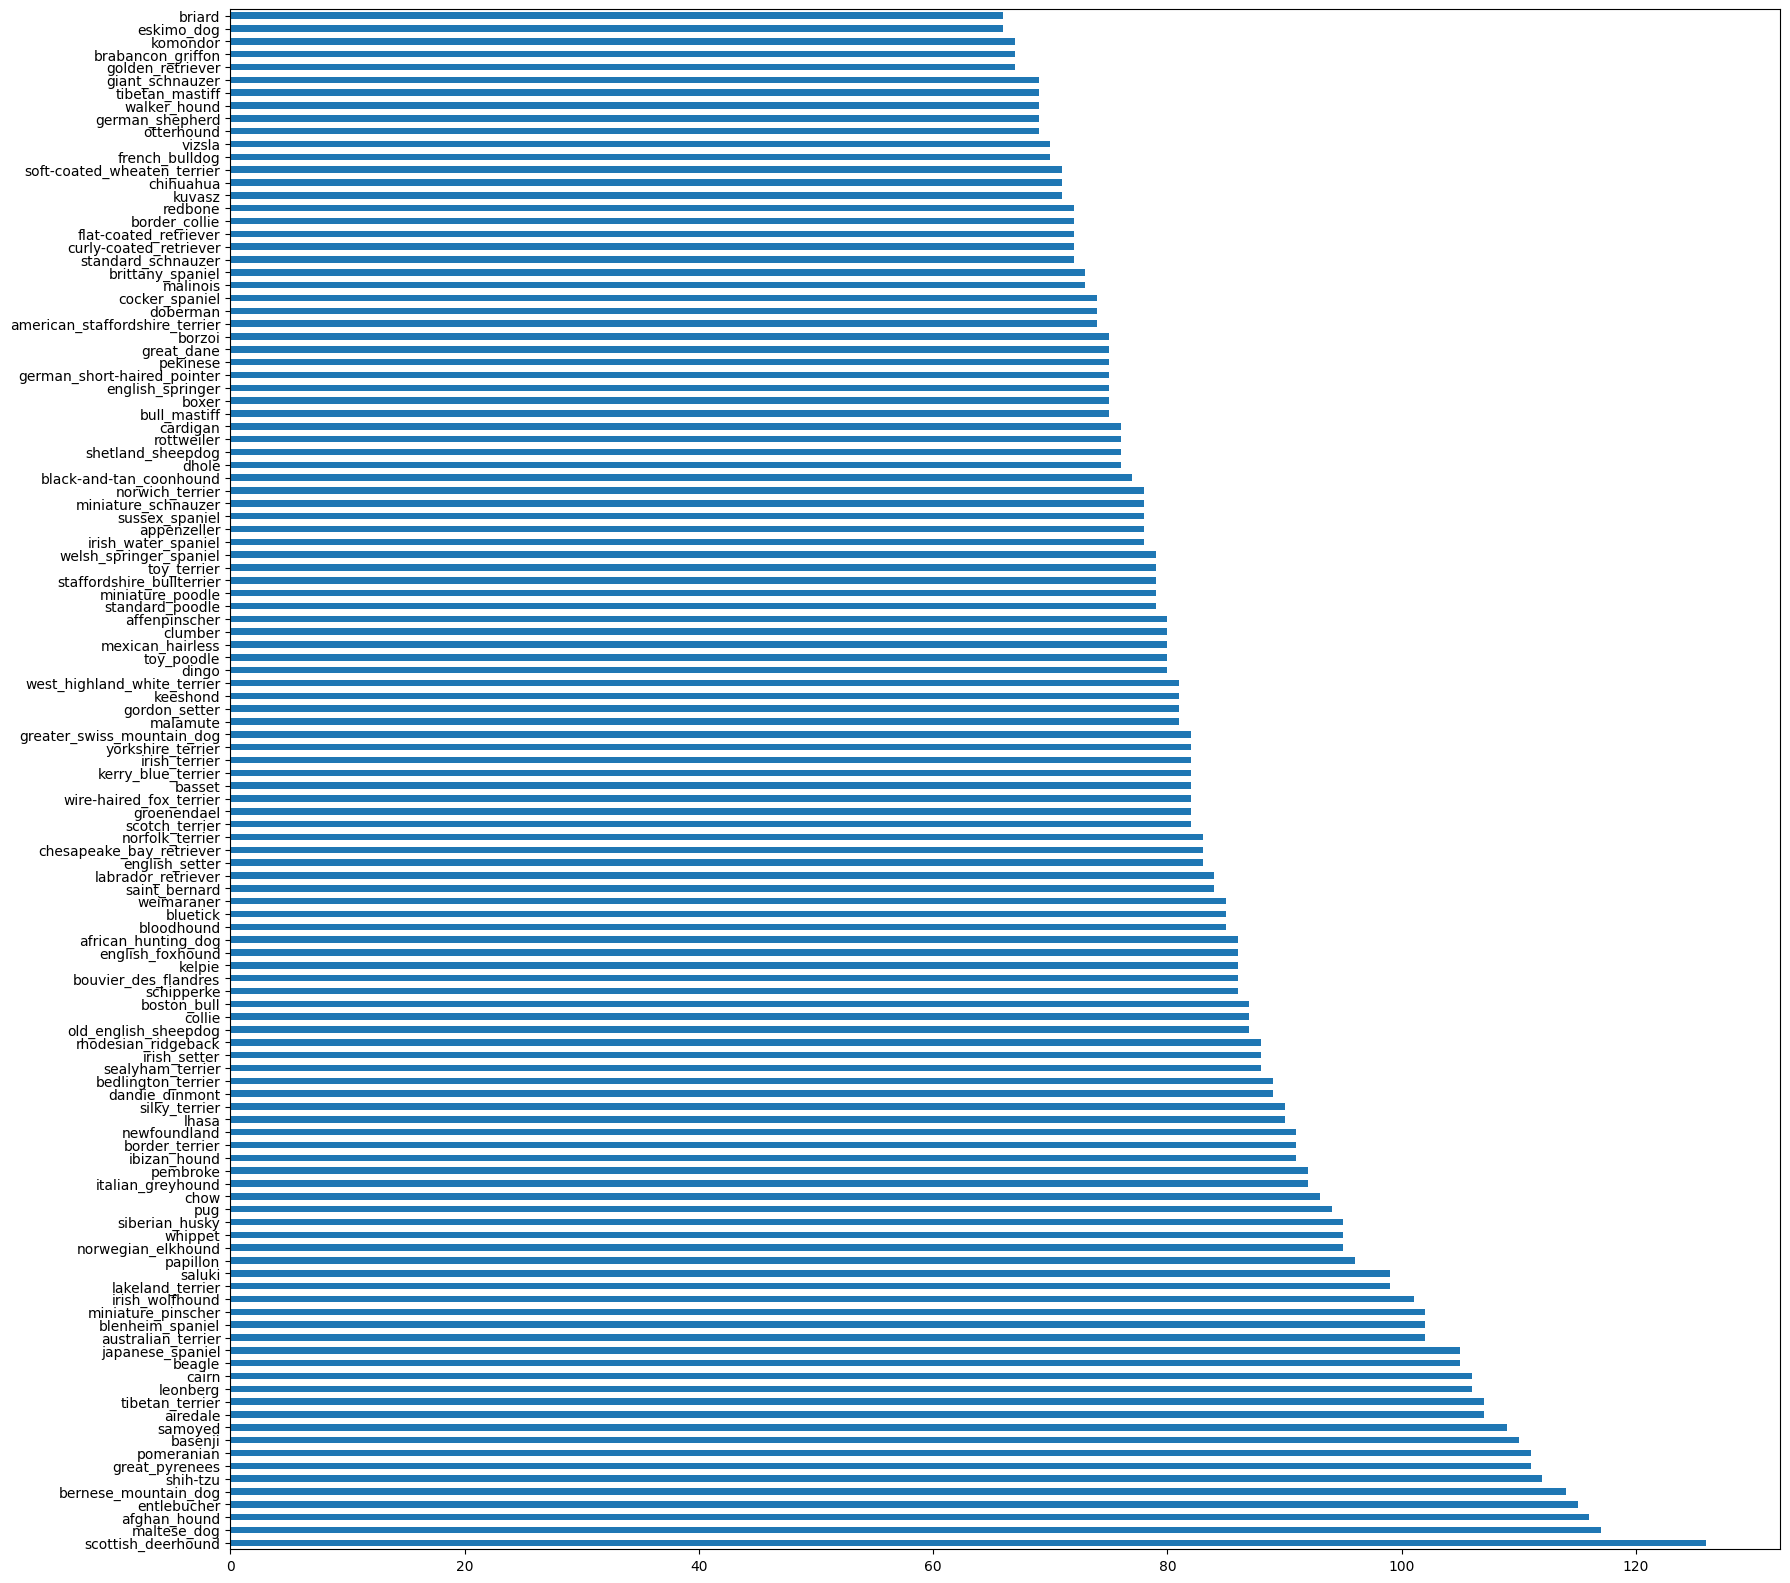

In [40]:
# How many daogs in each breed
labels_csv["breed"].value_counts().plot.barh(figsize=(20,20))

In [41]:
labels_csv.isna().value_counts

<bound method DataFrame.value_counts of           id  breed
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
10217  False  False
10218  False  False
10219  False  False
10220  False  False
10221  False  False

[10222 rows x 2 columns]>

In [42]:
# Convert labels to Numpy array
labels =  labels_csv["breed"].to_numpy()
len(labels)

10222

In [43]:
# Turn into array of booleans
unique_breeds = np.unique(labels)
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [44]:
#Getting file paths
filenames = ["drive/My Drive/DogBreedData/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/DogBreedData/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/DogBreedData/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/DogBreedData/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/DogBreedData/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/DogBreedData/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/DogBreedData/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/DogBreedData/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/DogBreedData/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/DogBreedData/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/DogBreedData/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [45]:
# Setup X and Y
X = filenames
Y= boolean_labels

In [46]:
# Set number of images to use
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:100}

In [47]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X[:NUM_IMAGES], Y[:NUM_IMAGES], test_size=0.2, random_state=42)
len(X_train), len(X_val), len(Y_train), len(Y_val)

(800, 200, 800, 200)

# @title Preprocessing Images

To preprocess our images into Tensors
1. Take and image file path as input
2. Use Tensorflow to read the file asn it into variable
3. Turn image to Tensors
4. Normailze Image (0-255 to 0-1)
5. Resize image to (224, 224)
6. Return the modified image

In [48]:
# Define Image Size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path):
  """
  Takes an image file path and turn the image into a tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg into numerical Tensor RGB
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert color channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

  return image

# Turning our data into batches
if we are trying to process all images at once will not fit into memory
Hence we nedd to process them in batches

In order to use TensorFlow we need our data in the foem of Temsor tuples like this:
`(image, label)`

In [49]:
# Simple function to retuen tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path name and assosiated label ,
  processes image and return a type of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [50]:
# Function to turn all data X n Y into batches
BATCH_SIZE = 32

def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (Y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data
  Also accepts test data as input (no labels).
  """
  # if data is test data set
  data_batch = None
  if test_data:
    print("Creating test data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating validation data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
     print("Creating training data batches....")
     #Turn filepaths and labels into Tensors
     data =  tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))

     #Shuffling pathnames and lebls before mapping image processor function faster than shuffling images
     data = data.shuffle(buffer_size=len(X))
     data = data.map(get_image_label)
     data_batch = data.batch(BATCH_SIZE)
     return data_batch


In [51]:
train_data = create_data_batches(X_train, Y_train)
val_data = create_data_batches(X_val, Y_val, valid_data=True)

Creating training data batches....
Creating validation data batches....


In [52]:
# Check out different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

#Visualizing data batches

In [53]:
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and theor labels from a data batch
  """
  #Setup figure
  plt.figure(figsize=(10,10))
  #Loop through 25
  for i in range(25):
    #Createsubplots
    ax = plt.subplot(5, 5, i+1)
    #Display image
    plt.imshow(images[i])
    #Add image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")


In [54]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [55]:
cd /content

/content


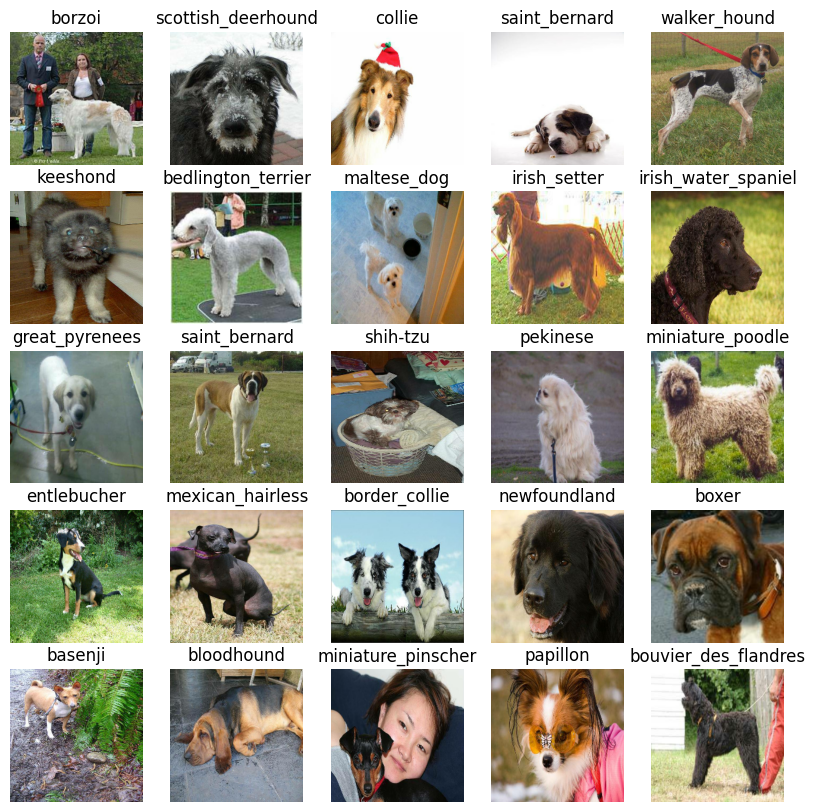

In [56]:
#Taking out label and Image from batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [57]:
#Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # Btach, height, width, color channels

# Setup output shape of Model
OUTPUT_SHAPE = len(unique_breeds)

#Setup model URL
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1"

In [58]:
#Keras Deeplearning Model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  #Setup the model layers
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL),  # Layer 1 inputlayer
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                               activation="softmax")]) #Layer 2 output layer

  #Compile Model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["Accuracy"]
  )

  #Build model
  model.build(INPUT_SHAPE)
  return model

In [59]:
model = create_model()
model.summary()

Building model with: https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Callbacks
Callbacks are helper Fns a model can use during traning to do such thing as save its progress, check its progress or stop  training earlt if it stop improving

Will have 2 callbacks
1. To keep track of progress.
2. Stop when not imporving.

In [60]:
# Tensorboard call back

#Load tensorboard
%load_ext tensorboard

import datetime

#Create function to build TensorBoardLogs
def create_tensorboard_callabck():
  logdir = os.path.join("drive/My Drive/DogBreedData/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [61]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)